# Global Research Progress of Endothelial Cells and ALI/ARDS: A bibliometric analysis

# 1 Load Python packages

In [1]:
import pandas as pd
import numpy as np  
import csv
import os
from collections import Counter
import pandas as pd
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import matplotlib.pyplot as plt

Rename the "Plain Text File" exported from WOS as WOS_1.txt and WOS_2.txt, then move them to the same folder as this file.

## Read the txt file and test the number of citations read.

In [246]:
def count_records(contents):
    # Initialize the count of records
    record_count = 0
    # Process each file content
    for content in contents:
        # Convert the list to a string and split by line
        lines = ''.join(content).split('\n')
        # Count all lines starting with "ER" and add to the record count
        record_count += sum(1 for line in lines if line.startswith('ER'))
    # Return the count of records
    return record_count

# Read and count the number of records in two txt files
with open('WOS_1.txt', 'r', encoding='utf-8-sig') as file1:
    content1 = file1.readlines()
with open('WOS_2.txt', 'r', encoding='utf-8-sig') as file2:
    content2 = file2.readlines()
# Combine the contents of the two files and count the records
contents = [content1, content2]
print(f"The combined txt files contain {count_records(contents)} records.")

The combined txt files contain 972 records.


# 2 Data Cleaning: Replacing Keywords, Authors, and Country Names

## 2.1 Modifying Author Keywords

### 2.1.1 Extract Author Keywords: Extract the lines in the txt file that contain the DE field (author keywords).

In [247]:
def extract_keywords(contents):
    # Initialize the keyword list
    keywords = []
    # Process each file content
    for content in contents:
        # Convert the list to a string and split by line
        lines = ''.join(content).split('\n')
        # Initialize a flag indicating whether we are processing a keyword line
        in_keywords = False
        # Iterate over all lines
        for line in lines:
            # If the line starts with "DE", add the line (removing the "DE" at the beginning) to the keyword list
            if line.startswith('DE '):
                keywords.append(line[3:])
                in_keywords = True
            # If the line does not start with "DE", starts with a space, but the previous line was a keyword line, append this line (removing the space at the beginning) to the previous line
            elif in_keywords and line.startswith(' '):
                keywords[-1] += ' ' + line.lstrip()  # Add a space and remove the space at the beginning
            else:
                in_keywords = False
    # Return the keyword list
    return keywords

# Read and extract keywords from two txt files
with open('WOS_1.txt', 'r', encoding='utf-8-sig') as file1:
    content1 = file1.readlines()
with open('WOS_2.txt', 'r', encoding='utf-8-sig') as file2:
    content2 = file2.readlines()
# Combine the contents of the two files and extract keywords
contents = [content1, content2]
keywords = extract_keywords(contents)
print(f"Extracted {len(keywords)} author keywords lines.")

# Print all keywords
for keyword in keywords:
    print(keyword)

Extracted 754 author keywords lines.
Sema3A; ARDS; inflammation; oxidative stress; ERK; JNK signalling
miR-223; inflammatory disease; acute lung injury (ALI); asthma; chronic obstructive pulmonary disease (COPD); COVID-19
acute lung injury; inactive rhomboid-like protein 2; C-X3-C motif chemokine ligand 1; inflammation; oxidative stress
pulmonary; inflammation; vascular endothelium; allogeneic bone marrow transplantation; murine models; cytokines
Sepsis; Acute lung injury; ERR alpha; Apoptosis; Autophagy
heparinase; ARDS; exosome; inflammation; coagulation; fibrosis; autophagy
metformin; PP2A; cofilin-1; vascular endothelial cells; acute lung injury
acute respiratory distress syndrome; endothelial dysfunction; sub-phenotypes; microcirculation; sepsis; intensive care
Acute lung injury; apoptosis; endothelium; inflammation; vascular endothelial glycocalyx
endothelial cells; cytoskeleton; permeability; Ser; Thr protein phosphatase 1; Thr protein phosphatase 2A; phosphorylation; inflammati

### 2.1.2 Writing Keywords to CSV File

In [248]:
# Extract keywords and write them into a CSV file
def write_keywords_to_csv(keywords, output_file):
    with open(output_file, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for keyword in keywords:
            writer.writerow([keyword])

# Use the above function to write keywords into 'wos_keywords.csv' file
write_keywords_to_csv(keywords, 'wos_keywords.csv')
print(f"Keywords exported to wos_keywords.csv")

Keywords exported to wos_keywords.csv


### 2.1.3 Extracting Unique Values of Keywords

In [249]:
# Read keywords from a file
def read_keywords_from_csv(input_file):
    keywords = []
    with open(input_file, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        for row in reader:
            keywords.extend(row[0].split(';'))
    return keywords

# Write keywords to a file
def write_keywords_to_csv(keywords, output_file):
    with open(output_file, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for keyword in keywords:
            writer.writerow([keyword])

# Read keywords from 'wos_keywords.csv' file
keywords = read_keywords_from_csv('wos_keywords.csv')

# Remove blank and duplicate keywords, then convert to list format
unique_keywords = list(set([k.strip() for k in keywords if k.strip()]))

# Calculate the number of unique keywords
print(f"The number of unique keywords: {len(unique_keywords)}")

# Write unique keywords to 'wos_unique_keywords.csv' file
write_keywords_to_csv(unique_keywords, 'wos_unique_keywords.csv')
print(f"Unique keywords exported to wos_unique_keywords.csv")

The number of unique keywords: 2082
Unique keywords exported to wos_unique_keywords.csv


### 2.1.4 Manually verify similar keywords and create a replacement CSV file.

- Create a file named "replacefile_authorkeywords.csv" with two columns: "Original Keyword" and "Processed Keyword".
- The column "Original Keyword" is derived from the file wos_unique_keywords.csv, while the column "Processed Keyword" stores the replaced keywords.
- For keywords that do not require any modifications, simply leave the 'Processed Keyword' column blank.

### 2.1.5 Replace Keywords and Export a New txt File

In [250]:
# Read the keyword mapping
df = pd.read_csv('replacefile_authorkeywords.csv')
keyword_mapping = df.set_index('Original Keyword')['Processed Keyword'].replace(np.nan, '', regex=True).to_dict()

def replace_keywords(string, keyword_mapping):
    keywords = string.split(";")
    new_keywords = [keyword_mapping.get(k.strip(), k.strip()) if keyword_mapping.get(k.strip(), k.strip()) not in [None, ""] else k.strip() for k in keywords]
    # Removing duplicate keywords
    new_keywords = list(dict.fromkeys(new_keywords))
    # Rejoin keywords with semicolon and space
    new_string = "; ".join(new_keywords)
    if not new_string.endswith(" "): # Ensure the string ends with a space
        new_string += " "
    return new_string

# Process the two txt files
for filename in ['WOS_1.txt', 'WOS_2.txt']:
    with open(filename, 'r', encoding='utf-8-sig') as file:
        content = file.readlines()

    new_content = []
    in_keywords = False
    current_line = ""

    for line in content:
        # If the line starts with "DE", it is the start of a keyword line
        if line.startswith('DE '):
            if in_keywords:
                # Replace keywords in current line and append to new content
                current_line = replace_keywords(current_line, keyword_mapping)
                new_content.append(f'DE {current_line}\n')
            # Start a new keyword line
            current_line = line[3:].strip()
            in_keywords = True
        # If the line doesn't start with "DE" but is a continuation of a keyword line, append it to the current line
        elif in_keywords and line.startswith(' '):
            current_line += ' ' + line.strip()
        # If the line is not a keyword line, append it to the new content
        else:
            if in_keywords:
                current_line = replace_keywords(current_line, keyword_mapping)
                new_content.append(f'DE {current_line}\n')
                current_line = ""
                in_keywords = False
            new_content.append(line)

    # Write the new content to a new file
    with open('01_updated_' + filename, 'w', encoding='utf-8-sig') as file:
        file.writelines(new_content)

print("Author keywords have been replaced and duplicates removed! The updated file names are: 01_updated_WOS_1.txt and 01_updated_WOS_2.txt.")

Author keywords have been replaced and duplicates removed! The updated file names are: 01_updated_WOS_1.txt and 01_updated_WOS_2.txt.


## 2.2 Modifying the Author's Name

### 2.2.1 Extracting Author Names: Extract author names based on the AF field.

In [251]:
# Define the file paths
file_paths = ["01_updated_WOS_1.txt", "01_updated_WOS_2.txt"]

# Initialize a list to collect authors
authors_from_af_corrected_multiline = []

# Loop through the files and extract authors from the AF field
for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8-sig', errors='ignore') as file:
        in_af_field = False
        for line in file:
            if line.startswith("AF"):
                in_af_field = True
                authors_from_af_corrected_multiline.append(line[3:].strip())
            elif in_af_field and line.startswith(" "):
                authors_from_af_corrected_multiline.append(line.strip())
            elif in_af_field and not line.startswith(" "):
                # Exiting the AF field
                in_af_field = False

# Counting the publication count for each author
author_publication_count_af_multiline = Counter(authors_from_af_corrected_multiline)

# Creating a DataFrame from the author publication counts
author_df_af_multiline = pd.DataFrame(list(author_publication_count_af_multiline.items()), columns=['Author', 'Publication Count'])

# Sorting by publication count
author_df_af_multiline = author_df_af_multiline.sort_values(by='Publication Count', ascending=False)

# Exporting to CSV
csv_file_path_af_multiline = "wos_authornames_original.csv"
author_df_af_multiline.to_csv(csv_file_path_af_multiline, index=False)

print(f"The original author's name has been saved to {csv_file_path_af_multiline}")


The original author's name has been saved to wos_authornames_original.csv


### 2.2.2 Manual Verification of Author Names

- Create a file called "replacefile_authornames.csv" with two columns, namely "Author" and "Replace by".
- The content of the "Author" column comes from the resource "wos_authornames_original.csv", and the "replace by" column contains replacement content.

### 2.2.3 Replace the Author's Name and Export It as a New txt File.

In [252]:
# Read the replacement file
replace_df = pd.read_csv('replacefile_authornames.csv')
# Create a dictionary with 'Author' as key and 'replace by' as value
replace_dict = replace_df.set_index('Author')['replace by'].to_dict()

# Iterate and modify files
for filename in ['01_updated_WOS_1.txt', '01_updated_WOS_2.txt']:
    # Open the file in read mode
    with open(filename, 'r', encoding='utf-8-sig') as file:
        # Read all lines from the file
        content = file.readlines()

    new_content = []
    in_af_line = False
    # Iterate over each line in the content
    for line in content:
        # Check if the line starts with 'AF'
        if line.startswith('AF'):
            in_af_line = True
            # Get the author name starting from the 3rd character
            author = line[3:].strip()
            # Get the new author name from the dictionary, if not found use the original author name
            new_author = replace_dict.get(author, author)
            # Append the new author name to the new content
            new_content.append('AF ' + new_author + '\n')
        # Check the condition for the end of the 'AF' field
        elif in_af_line and not line.startswith(' '):
            in_af_line = False
            new_content.append(line)
        elif in_af_line:
            # Remove leading and trailing spaces from the line
            author = line.strip()
            # Check if the author needs to be replaced
            new_author = replace_dict.get(author, author)
            # Append the new content with spaces at the beginning
            new_content.append('   ' + new_author + '\n')
        else:
            new_content.append(line)

    # Write to a new file, the new filename is the original filename with a '_updated' suffix
    new_filename = '02_' + filename.replace('01_', '') 
    with open(new_filename, 'w', encoding='utf-8-sig') as file:
        # Write all lines to the file
        file.writelines(new_content)

print("The author's name has been replaced successfully, and the new file is saved as 02_updated_WOS_1.txt and 02_updated_WOS_1.txt!")

The author's name has been replaced successfully, and the new file is saved as 02_updated_WOS_1.txt and 02_updated_WOS_1.txt!


## 2.3 Modifying Country Names

### 2.3.1 Manually Creating a Country Name Replacement File

- Create a file named "replacefile_countrynames.csv" with two columns: one column for the "Country" and another column for the "replace by".

### 2.3.2 Replace country names and export as a new txt file

In [253]:
# Read replacement content from CSV file
replace_dict = {}
with open('replacefile_countrynames.csv', 'r', encoding='utf-8-sig') as csv_file:
    reader = csv.reader(csv_file)
    next(reader)  # Skip the header row
    for row in reader:
        replace_dict[row[0]] = row[1]

# Read the original file and write the replaced content to a new file
input_files = ['02_updated_WOS_1.txt', '02_updated_WOS_2.txt']
for input_file in input_files:
    output_file = '03_' + input_file.replace('02_', '')
    with open(input_file, 'r', encoding='utf-8-sig') as infile, open(output_file, 'w', encoding='utf-8-sig') as outfile:
        in_c1_section = False
        for line in infile:
            if line.startswith('C1'):
                in_c1_section = True
            elif not line.startswith(' '):
                in_c1_section = False
                
            # Replace the country name in the C1 section
            if in_c1_section:
                for original, replacement in replace_dict.items():
                    line = line.replace(original, replacement)
            outfile.write(line)

print("The country name has been successfully replaced, and the new file is saved as 03_updated_WOS_1.txt and 03_updated_WOS_1.txt!")

The country name has been successfully replaced, and the new file is saved as 03_updated_WOS_1.txt and 03_updated_WOS_1.txt!


## 2.4 Correction of citation txt errors

- When comparing the analysis results of VOSviewer, Python code, and Web of Science (WoS) data retrieval, it was found that both VOSviewer and Python code reported one less publication count for articles from the United Kingdom compared to the analysis results obtained from WoS data retrieval. After careful manual verification, it was discovered that this discrepancy was due to an irregular format in the C1 field line of the citation file for the article titled "Select Rab GTPases Regulate the Pulmonary Endothelium via Endosomal Trafficking of Vascular Endothelial-Cadherin," which did not include the contact address of the corresponding author.
- To rectify this issue, we manually corrected the C1 field line in the citation file for "Select Rab GTPases Regulate the Pulmonary Endothelium via Endosomal Trafficking of Vascular Endothelial-Cadherin" by adding the contact address of the corresponding author. This correction ensures that there is no bias in our analysis when using VOSviewer or Python code.
- Furthermore, to prevent similar errors from occurring again in future analyses, we have marked all C1 field lines in our text files and used Python code to retrieve all non-standard format lines. These lines were then manually verified to confirm whether they included contact addresses for corresponding authors.

In [254]:
# Add a new line to the file after the specified line number
def insert_line(filename, line_num, text):
    with open(filename, 'r', encoding='utf-8-sig') as file:
        content = file.readlines()
    content.insert(line_num, text + '\n')  # Insert the new line
    return content

# Save the content to a new file
def save_to_file(filename, content):
    with open(filename, 'w', encoding='utf-8-sig') as file:
        file.writelines(content)

# Add the new line to 03_updated_WOS_2.txt and save as 05_final_WOS_2.txt
new_line = "   Anglia Ruskin Univ, Biomed Res Grp, Dept Life Sci, Fac Sci & Technol, OPT 024,East Rd, Cambridge CB1 1PT, England, United Kingdom."
updated_content = insert_line('03_updated_WOS_2.txt', 19691, new_line)
save_to_file('05_final_WOS_2.txt', updated_content)

# Save 03_updated_WOS_1.txt as 05_final_WOS_1.txt without any changes
with open('03_updated_WOS_1.txt', 'r', encoding='utf-8-sig') as file:
    content = file.readlines()
save_to_file('05_final_WOS_1.txt', content)

print("Files saved as 05_final_WOS_1.txt and 05_final_WOS_2.txt.")

Files saved as 05_final_WOS_1.txt and 05_final_WOS_2.txt.


### 2.4.1 Create txt files with all C1 field rows starting with C1: 04_C1updated_WOS_1.txt and 04_C1updated_WOS_2.txt

In [255]:
def modify_c1_lines(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    in_c1_section = False
    modified_lines = []
    for line in lines:
        if line.startswith("C1"):
            in_c1_section = True
        elif not line.startswith(" ") and in_c1_section:
            in_c1_section = False

        if in_c1_section and line.startswith(" "):
            # Replace lines beginning with spaces with lines that begin with "C1" and ensure that spaces are preserved
            line = "C1 " + line.lstrip()

        modified_lines.append(line)

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(modified_lines)

modify_c1_lines('03_updated_WOS_1.txt', '04_C1updated_WOS_1.txt')
modify_c1_lines('03_updated_WOS_2.txt', '04_C1updated_WOS_2.txt')

### 2.4.2 Check if there are any formatting errors in all C1 rows

In [256]:
file_paths = ['04_C1updated_WOS_1.txt', '04_C1updated_WOS_2.txt']

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        for line_number, line in enumerate(file, 1):
            if line.startswith('C1 ') and '[' not in line:
                print(f"In file {file_path}, line {line_number}: {line.strip()}")

In file 04_C1updated_WOS_1.txt, line 28285: C1 Ohio State Univ, Dept Pediat, Columbus, OH 43210, United States.
In file 04_C1updated_WOS_1.txt, line 33927: C1 Univ Georgia, Clin & Expt Therapeut, Augusta, GA 30912, United States.
In file 04_C1updated_WOS_1.txt, line 33928: C1 Charlie Norwood VA Med Ctr, Augusta, GA, United States.
In file 04_C1updated_WOS_1.txt, line 42817: C1 Univ Illinois, Dept Pharmacol, Chicago, IL 60612, United States.
In file 04_C1updated_WOS_1.txt, line 42818: C1 Univ Illinois, Ctr Lung & Vasc Biol, Chicago, IL 60612, United States.
In file 04_C1updated_WOS_1.txt, line 53522: C1 Wenzhou Med Univ, Affiliated Hosp 1, Wenzhou, Zhejiang 325000, China.
In file 04_C1updated_WOS_1.txt, line 57588: C1 Chinese Acad Med Sci, Peking Union Med Coll Hosp, Dept Cardiac Surg, Beijing, China.
In file 04_C1updated_WOS_1.txt, line 57589: C1 Peking Union Med Coll, Beijing, China.
In file 04_C1updated_WOS_2.txt, line 13690: C1 Univ Illinois, Div Pulm Crit Care Sleep & Allergy, Chic

### 2.4.3 Correcting Error in C1 Field Line

- Manually modify the final txt citation files: '05_final_WOS_1.txt', '05_final_WOS_2.txt' 
- Specifically, add a new line in the C1 field of the article "Select Rab GTPases Regulate the Pulmonary Endothelium via Endosomal Trafficking of Vascular Endothelial-Cadherin": "Anglia Ruskin University, Biomedical Research Group, Department of Life Sciences, Faculty of Science and Technology, OPT 024, East Road, Cambridge CB1 1PT, England, United Kingdom." 
- Manually modify the citation files for convenient analysis of institution and country data using Python code: '05_C1_WOS_1.txt', '05_C1_WOS_2.txt'.

In [257]:
# Insert a new line into the file 04_C1updated_WOS_2.txt.
with open("04_C1updated_WOS_2.txt", 'r', encoding='utf-8-sig') as file:
    lines = file.readlines()

new_line = "C1 Anglia Ruskin Univ, Biomed Res Grp, Dept Life Sci, Fac Sci & Technol, OPT 024,East Rd, Cambridge CB1 1PT, England, United Kingdom.\n"
lines.insert(19691, new_line)

with open("05_C1_WOS_2.txt", 'w', encoding='utf-8-sig') as file:
    file.writelines(lines)

# Copy the content of file 04_C1updated_WOS_1.txt to 05_C1_WOS_1.txt.
with open("04_C1updated_WOS_1.txt", 'r', encoding='utf-8-sig') as file:
    content = file.read()

with open("05_C1_WOS_1.txt", 'w', encoding='utf-8-sig') as file:
    file.write(content)

print("Files saved as 05_C1_WOS_1.txt and 05_C1_WOS_2.txt.")

Files saved as 05_C1_WOS_1.txt and 05_C1_WOS_2.txt.


# 3 Statistical Analysis: Number of Publications, Citation Frequency, h-index, and Other Data

- The annual number of publications and the annual citation frequency can be obtained through the citation report on the web version of the WOS database.
- The annual citation frequency cannot be obtained through a text citation file.

## 3.1 National Influence

### 3.1.1 Total Number of Publications and Multinational Publications

In [258]:
file_paths = ['05_C1_WOS_1.txt', '05_C1_WOS_2.txt']

# Create a dictionary to store the collaboration information of each country.
country_publications = defaultdict(int)
country_multinational_publications = defaultdict(int)

for file_path in sorted(file_paths):
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        countries = set()  # Used to store the country information for each article.
        for line in file:
            if line.startswith('C1 '):
                country = line.strip().rsplit(',', 1)[-1].strip() 
                if country.endswith('.'):
                    country = country[:-1]
                countries.add(country)
                # print(f"Found country: {country}") 

            # When an article comes to an end
            if line.startswith('ER'):
                # print(f"Ending record with countries: {countries}")  
                if len(countries) > 1:  # If there are multiple countries, it will be a collaborative article.
                    for country in countries:
                        country_multinational_publications[country] += 1
                for country in countries:
                    country_publications[country] += 1
                countries.clear()

# Output Result
with open('country_publications.csv', 'w', newline='', encoding='utf-8-sig') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Country', 'Publications', 'Multinational Publications'])
    sorted_countries = sorted(country_publications, key=lambda country: country_publications[country], reverse=True)
    for country in sorted_countries:
        writer.writerow([country, country_publications[country], country_multinational_publications[country]])

print("Data saved to 'country_publications.csv'.")

Data saved to 'country_publications.csv'.


### 3.1.2 Total Citations and h-index

In [259]:
file_paths = ['05_C1_WOS_1.txt', '05_C1_WOS_2.txt']
country_citations = defaultdict(int)
country_citation_list = defaultdict(list)

def calculate_h_index(citations):
    citations.sort(reverse=True)
    h_index = 0
    for i in range(len(citations)):
        if citations[i] >= i + 1:
            h_index = i + 1
        else:
            break
    return h_index

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        countries = set()
        for line in file:
            line = line.strip()

            # Extract country information from row C1 and add it to the collection of countries.
            if line.startswith('C1 '):
                country = line.rsplit(',', 1)[-1].strip()
                if country.endswith('.'):
                    country = country[:-1]
                countries.add(country)

            # If a TC row is found, add the citation count to the corresponding country's citation frequency.
            if line.startswith('TC '):
                try:
                    citation_count = int(line[3:].strip())
                except ValueError:
                    print(f"Skipping unexpected line: {line}")
                    continue
                for country in countries:
                    country_citations[country] += citation_count
                    country_citation_list[country].append(citation_count)
                countries.clear()

# Calculate the h-index for each country and sort them.
sorted_country_data = []
for country, citations in country_citations.items():
    h_index = calculate_h_index(country_citation_list[country])
    sorted_country_data.append((country, citations, h_index))

sorted_country_data.sort(key=lambda x: x[1], reverse=True)

# Save the results to a CSV file.
with open('country_citations_h-index.csv', 'w', newline='', encoding='utf-8-sig') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Country", "Citations", "h-index"])  
    for row in sorted_country_data:
        writer.writerow(row)

print("Data saved to 'country_citations_h-index.csv'.")

Data saved to 'country_citations_h-index.csv'.


### 3.1.3 number_of_cooperative_countries

In [260]:
file_paths = ['05_C1_WOS_1.txt', '05_C1_WOS_2.txt']
country_cooperative_countries = defaultdict(set)
all_countries = set()

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        countries = set()
        for line in file:
            # Find national information.
            if line.startswith('C1 '):
                country_part = line.split(",")[-1].strip()
                if country_part.endswith('.'):
                    country_part = country_part[:-1]
                country = " ".join(country_part.split(" ")[-2:])
                if country:
                    countries.add(country)
                    all_countries.add(country) # Storing all found countries
                # print(f"Found country: {country}")

            # When an article ends, add the cooperative relationships between countries to the dictionary "country_cooperative_countries".
            if line.startswith('ER'):
                if len(countries) > 1:
                    for country in countries:
                        country_cooperative_countries[country].update(countries - {country})
                countries.clear()

# Calculate the number of collaborating countries for each country.
country_number_of_cooperative_countries = {country: len(country_cooperative_countries.get(country, set())) for country in all_countries}

# Output Result
with open('country_number_of_cooperative_countries.csv', 'w', newline='', encoding='utf-8-sig') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Country', 'Number of Cooperative Countries'])
    for country, number_of_cooperative_countries in country_number_of_cooperative_countries.items():
        writer.writerow([country, number_of_cooperative_countries])

print("Calculation completed. Data saved to 'country_number_of_cooperative_countries.csv'.")

Calculation completed. Data saved to 'country_number_of_cooperative_countries.csv'.


### 3.1.4 Merging National Data Tables

In [261]:
# Read each CSV file.
h_indices_df = pd.read_csv('country_citations_h-index.csv')
cooperative_countries_df = pd.read_csv('country_number_of_cooperative_countries.csv')
publications_df = pd.read_csv('country_publications.csv')

# Merge these DataFrames using the "Country" column.
merged_df = h_indices_df.merge(cooperative_countries_df, on='Country', how='outer')
merged_df = merged_df.merge(publications_df, on='Country', how='outer')

# Fill in NaN values (if any).
merged_df.fillna(0, inplace=True)

# Calculate the column Average Citations per Publication.
merged_df['Average Citations per Publication'] = (merged_df['Citations'] / merged_df['Publications']).round(2)

# Calculate the share of publications from multinational collaborations.
merged_df['share of multinational cooperation publications'] = (merged_df['Multinational Publications'] / merged_df['Publications'] * 100).round(2)

# Reorganize according to the desired column order.
columns_order = [
    'Country', 'Publications', 'Citations', 'h-index',
    'Average Citations per Publication', 'Number of Cooperative Countries',
    'Multinational Publications', 'share of multinational cooperation publications'
]
merged_df = merged_df[columns_order]

# Sort in descending order by the columns 'Publications', 'Average Citations per Publication', and 'h-index'.
merged_df = merged_df.sort_values(by=['Publications', 'Average Citations per Publication', 'h-index'], ascending=False)

# Save to a new CSV file.
merged_df.to_csv('Data_Country.csv', index=False)

print("Files have been successfully merged and saved to 'Data_Country.csv'.")

Files have been successfully merged and saved to 'Data_Country.csv'.


## 3.2 institution

### 3.2.1 Total Publications, Citations, h-index and Country

In [262]:
file_paths = ['05_C1_WOS_1.txt', '05_C1_WOS_2.txt']
institution_publications = defaultdict(int)
institution_citations = defaultdict(int)
institution_citation_list = defaultdict(list)
institution_country = {}

def calculate_h_index(citations):
    citations.sort(reverse=True)
    h_index = 0
    for i in range(len(citations)):
        if citations[i] >= i + 1:
            h_index = i + 1
        else:
            break
    return h_index

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        institutions = set()
        for line in file:
            line = line.strip()

            # Extract institution and country information from line C1 and add it to the institution collection.
            if line.startswith('C1 '):
                if ']' in line:
                    institution = line.split(']')[-1].split(',')[0].strip()
                else:
                    institution = line.split('C1 ')[-1].split(',')[0].strip()

                # Extracting National Information
                country = line.split(",")[-1].strip()
                if country.endswith('.'):
                    country = country[:-1]

                institutions.add(institution)
                if institution not in institution_country:
                    institution_country[institution] = country

            # If a TC line is found, add the number of citations to the corresponding institution's citation frequency and update the institution's publication count.
            if line.startswith('TC '):
                try:
                    citation_count = int(line[3:].strip())
                except ValueError:
                    print(f"Skipping unexpected line: {line}")
                    continue
                for institution in institutions:
                    institution_citations[institution] += citation_count
                    institution_publications[institution] += 1
                    institution_citation_list[institution].append(citation_count)
                institutions.clear()

# Calculate the h-index for each institution and sort them.
sorted_institution_data = []
for institution, count in institution_publications.items():
    h_index = calculate_h_index(institution_citation_list[institution])
    sorted_institution_data.append((institution, count, institution_citations[institution], h_index))

sorted_institution_data.sort(key=lambda x: x[1], reverse=True)

# Save the results to a CSV file.
with open('institution_data.csv', 'w', newline='', encoding='utf-8-sig') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Institution", "Country", "Publications", "Citations", "h-index"])  # 添加国家列
    for institution, count in institution_publications.items():
        country = institution_country.get(institution, "Unknown")
        h_index = calculate_h_index(institution_citation_list[institution])
        writer.writerow([institution, country, count, institution_citations[institution], h_index])

print("Data saved to 'institution_data.csv'.")

Data saved to 'institution_data.csv'.


### 3.2.2 Institutional Data Table

In [263]:
total_publications = 972

with open('institution_data.csv', 'r', encoding='utf-8-sig') as infile:
    reader = csv.DictReader(infile)
    data = [row for row in reader]

# Processing data, adding new columns.
for row in data:
    publications = int(row['Publications'])
    citations = int(row['Citations'])
    row['Average Citations per Publication'] = round(citations / publications, 2)
    row['the percentage of articles of institutions in total publications'] = round((publications / total_publications) * 100, 2)

# Define a new column name.
fieldnames = [
    'Institution', 'Publications', 'Citations', 'h-index', 'Average Citations per Publication',
    'the percentage of articles of institutions in total publications', 'Country'
]

# Sort in descending order according to the desired column.
sorted_data = sorted(data, key=lambda x: (
    int(x['Publications']), float(x['Average Citations per Publication']), int(x['h-index'])
), reverse=True)

# Write the updated data into a new CSV file.
with open('Data_Institution.csv', 'w', newline='', encoding='utf-8-sig') as outfile:
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(sorted_data)

print("New columns added and sorted successfully. Data saved to 'Data_Institution.csv'.")

New columns added and sorted successfully. Data saved to 'Data_Institution.csv'.


## 3.3 Analysis of Author's Influence

### 3.3.1 Total Number of Publications

In [265]:
# Define the file paths
file_paths = ["05_final_WOS_1.txt", "05_final_WOS_2.txt"]

# Initialize a list to collect authors
authors_from_af_corrected_multiline = []

# Loop through the files and extract authors from the AF field
for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8-sig', errors='ignore') as file:
        in_af_field = False
        for line in file:
            if line.startswith("AF"):
                in_af_field = True
                authors_from_af_corrected_multiline.append(line[3:].strip())
            elif in_af_field and line.startswith(" "):
                authors_from_af_corrected_multiline.append(line.strip())
            elif in_af_field and not line.startswith(" "):
                # Exiting the AF field
                in_af_field = False

# Counting the publication count for each author
author_publication_count_af_multiline = Counter(authors_from_af_corrected_multiline)

# Creating a DataFrame from the author publication counts
author_df_af_multiline = pd.DataFrame(list(author_publication_count_af_multiline.items()), columns=['Author', 'Publication Count'])

# Sorting by publication count
author_df_af_multiline = author_df_af_multiline.sort_values(by='Publication Count', ascending=False)

# Exporting to CSV
csv_file_path_af_multiline = "author_publications.csv"
author_df_af_multiline.to_csv(csv_file_path_af_multiline, index=False)

print(f"CSV file exported to {csv_file_path_af_multiline}")

CSV file exported to author_publications.csv


### 3.3.2 Total Citation Frequency

In [266]:
# List of File Names
filenames = ["05_final_WOS_1.txt", "05_final_WOS_2.txt"]

# Dictionary used to store the author and their total citation count.
author_citation_counts = {}


# Loop through each file.
for filename in filenames:
    authors = []  # Store a list of authors for an article.
    in_af_field = False # Indicate whether it is within the AF field.
    with open(filename, 'r', encoding='utf-8-sig') as file:
        for line in file:
            # If in the AF field
            if line.startswith('AF'):
                authors.append(line[3:].strip())
                in_af_field = True
            elif in_af_field and line.strip() and line[0] == ' ':
                authors.append(line.strip())
            else:
                in_af_field = False # Not in the AF field.

            # If in the TC field
            if line.startswith('TC'):
                citation_count = int(line[3:].strip())
                for author in authors:
                    author_citation_counts[author] = author_citation_counts.get(author, 0) + citation_count
                authors = []  # Reset the list of authors for the next article.

# Print the author and their total citation count.
# for author, citations in author_citation_counts.items():
    # print(f"{author}: {citations} citations")

with open('author_citations.csv', 'w', encoding='utf-8-sig', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Author', 'Citations'])
    for author, citations in author_citation_counts.items():
        writer.writerow([author, citations])

print("Data saved to 'author_citations.csv'.")

Data saved to 'author_citations.csv'.


### 3.3.3 h-index

In [267]:
filenames = ['05_final_WOS_1.txt', '05_final_WOS_2.txt']

# Store a list of citation counts for each author.
author_citations = defaultdict(list)

# Read the file line by line.
for filename in filenames:
    authors = []  # Store the authors of the current paper.
    in_af_field = False # True if the current line is in the AF field.
    with open(filename, 'r', encoding='utf-8-sig') as file:
        for line in file:
            # IF the current line is in the AF field, append the author to the list.
            if line.startswith('AF'):
                authors.append(line[3:].strip())
                in_af_field = True
            elif in_af_field and line.strip() and line[0] == ' ':
                authors.append(line.strip())
            else:
                in_af_field = False 

            # IF the current line is in the TC field, append the citation count to the list.
            if line.startswith('TC'):
                citation_count = int(line[3:].strip())
                for author in authors:
                    author_citations[author].append(citation_count)
                authors = []  # Reset the list of authors.

#  Calculate the h-index for each author.
author_h_indexes = {}
for author, citations in author_citations.items():
    citations.sort(reverse=True)
    h_index = 0
    for i, citation in enumerate(citations):
        if citation >= i + 1:
            h_index = i + 1
        else:
            break
    author_h_indexes[author] = h_index

# Write the author h-indexes to a CSV file.
with open('author_h_index.csv', 'w', encoding='utf-8-sig', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Author', 'h-index'])
    for author, h_index in author_h_indexes.items():
        writer.writerow([author, h_index])

print("Data saved to 'author_h_index.csv'.")

Data saved to 'author_h_index.csv'.


### 3.3.4 Obtain the author's latest affiliation with an institution or country

In [268]:
def extract_latest_institution_country(file_path):
    author_institution = {}
    author_country = {}
    # Read the file line by line
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        for line in file:
            if line.startswith("C1"):
                match = re.match(r"C1 \[(.*?)\](.*)", line)
                if match:
                    authors = [author.strip() for author in match.group(1).split(";")]
                    institution_country_info = match.group(2)
                    institution_parts = institution_country_info.split(",")
                    institution = institution_parts[0].strip()
                    country = institution_parts[-1].strip()
                    if country.endswith('.'):
                        country = country[:-1]
                    for author in authors:
                        if author and author not in author_institution:
                            author_institution[author] = institution
                            author_country[author] = country
    # Return the extracted data
    return author_institution, author_country

# Read the replacefile_authornames.csv and build a dictionary to hold the replacements
replacements = {}
with open('replacefile_authornames.csv', 'r', encoding='utf-8-sig') as file:
    reader = csv.reader(file)
    next(reader)  # skip the header row
    for row in reader:
        original_name, replace_by = row
        replacements[original_name] = replace_by
# Extract the latest institution and country for each author
file_paths = ['05_C1_WOS_1.txt', '05_C1_WOS_2.txt']
all_author_institution = {}
all_author_country = {}
# Loop through all the files and extract the data
for file_path in file_paths:
    author_institution, author_country = extract_latest_institution_country(file_path)
    all_author_institution.update(author_institution)
    all_author_country.update(author_country)
# Write the extracted data to a CSV file
with open('authors_institutions_countries.csv', 'w', newline='', encoding='utf-8-sig') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Author", "Institution", "Country"])
    seen_authors = set()
    for author in all_author_institution:
        # Apply replacements if needed
        final_author_name = replacements.get(author, author)
        if final_author_name not in seen_authors:
            seen_authors.add(final_author_name)
            country = all_author_country[author]
            writer.writerow([final_author_name, all_author_institution[author], country])

print("Extraction completed. Data saved to 'authors_institutions_countries.csv'.")

Extraction completed. Data saved to 'authors_institutions_countries.csv'.


### 3.3.5 Merging Author Influence Tables

In [269]:
# Read four CSV files
citations_df = pd.read_csv('author_citations.csv')
h_index_df = pd.read_csv('author_h_index.csv')
publications_df = pd.read_csv('author_publications.csv')
authors_institutions_countries_df = pd.read_csv('authors_institutions_countries.csv')

# Merge dataframes based on 'Author' column, use 'inner' to only keep authors found in 'author_citations.csv'
merged_df = pd.merge(citations_df, h_index_df, on='Author', how='left')
merged_df = pd.merge(merged_df, publications_df, on='Author', how='left')
merged_df = pd.merge(merged_df, authors_institutions_countries_df, on='Author', how='left')

# Calculate average citation value, keep two decimal places
merged_df['Average Citations per Publication'] = (merged_df['Citations'] / merged_df['Publication Count']).round(2)

# Rename column names
merged_df.rename(columns={'Publication Count': 'Publications', 'h-index': 'h-index'}, inplace=True)

# Rearrange the columns in the required order
merged_df = merged_df[['Author', 'Publications', 'Citations', 'h-index', 'Average Citations per Publication', 'Institution', 'Country']]

# Sort by 'Publications', 'Average Citations per Publication', and 'h-index' columns in descending order
merged_df = merged_df.sort_values(by=['Publications', 'Average Citations per Publication', 'h-index'], ascending=[False, False, False])

# Save the result to a new CSV file
merged_df.to_csv('Data_Author.csv', index=False, encoding='utf-8-sig')

print("Data saved to 'Data_Author.csv'.")

Data saved to 'Data_Author.csv'.


## 3.4 Journal

### 3.4.1 Publications, Citations, ACPP, and TPR

In [ ]:
file_paths = ["05_final_WOS_1.txt", "05_final_WOS_2.txt"]
journal_publications = defaultdict(int)
journal_citations = defaultdict(int)
total_publications = 972

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        current_journal = None
        for line in file:
            line = line.strip()

            if line.startswith('SO '):
                current_journal = line[3:].strip()

            if line.startswith('TC ') and current_journal:
                try:
                    citation_count = int(line[3:].strip())
                    journal_citations[current_journal] += citation_count
                    journal_publications[current_journal] += 1
                except ValueError:
                    print(f"Skipping unexpected line: {line}")
                    continue
                current_journal = None

# Preparing data.
data = []
for journal, publications in journal_publications.items():
    citations = journal_citations[journal]
    avg_citations_per_publication = round(citations / publications, 2)
    percentage_of_articles = round((publications / total_publications) * 100, 2)
    data.append((journal, publications, citations, avg_citations_per_publication, percentage_of_articles))

# Sort in descending order by the number of posts.
sorted_data = sorted(data, key=lambda x: x[1], reverse=True)

# Save the sorted results to a CSV file.
with open('Data_Journal.csv', 'w', newline='', encoding='utf-8-sig') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Journal", "Publications", "Citations", "Average Citations per Publication",
                     "the percentage of articles of institutions in total publications"])
    writer.writerows(sorted_data)

print("Data saved to 'Data_Journal.csv'.")

### 3.4.2 Bubble_journal_data

In [2]:
file_paths = ['05_final_WOS_1.txt', '05_final_WOS_2.txt']
journal_publications = defaultdict(int)
journal_yearly_publications = defaultdict(lambda: defaultdict(int))

# Save all occurrence years
all_years = set()

# Journal used for storing current literature.
current_journal = ''

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        for line in file:
            line = line.strip()

            # Read the SO line and save the journal.
            if line.startswith('SO '):
                current_journal = line[3:].strip()

            # Read the PY line, associated with the current journal
            elif line.startswith('PY '):
                try:
                    publication_year = int(line[3:].strip())
                    all_years.add(publication_year)

                    # If there are journals, conduct statistics.
                    if current_journal:
                        journal_publications[current_journal] += 1
                        journal_yearly_publications[current_journal][publication_year] += 1

                    # Clear the current journal and prepare to process the next document.
                    current_journal = ''

                except ValueError:
                    print(f"Skipping unexpected line: {line}")
                    continue

all_years = sorted(list(all_years))

# Create a list to store journals and their corresponding data.
journals_data = []

# Save data to a list.
for journal, total_count in journal_publications.items():
    row = [journal, total_count] + [journal_yearly_publications[journal][year] for year in all_years]
    journals_data.append(row)

# Sort in descending order based on the value of the "total publications" column.
journals_data.sort(key=lambda x: x[1], reverse=True)

# Save the sorted results
with open('Bubble_journals_data.csv', 'w', newline='', encoding='utf-8-sig') as csvfile:
    writer = csv.writer(csvfile)
    header = ["journal", "total publications"] + [str(year) for year in all_years]
    writer.writerow(header)
    for row in journals_data:
        writer.writerow(row)

print("Data saved to 'Bubble_journals_data.csv'.")

Data saved to 'Bubble_journals_data.csv'.


### 3.4.3 Bubble Chart of Top 20 journal by Year

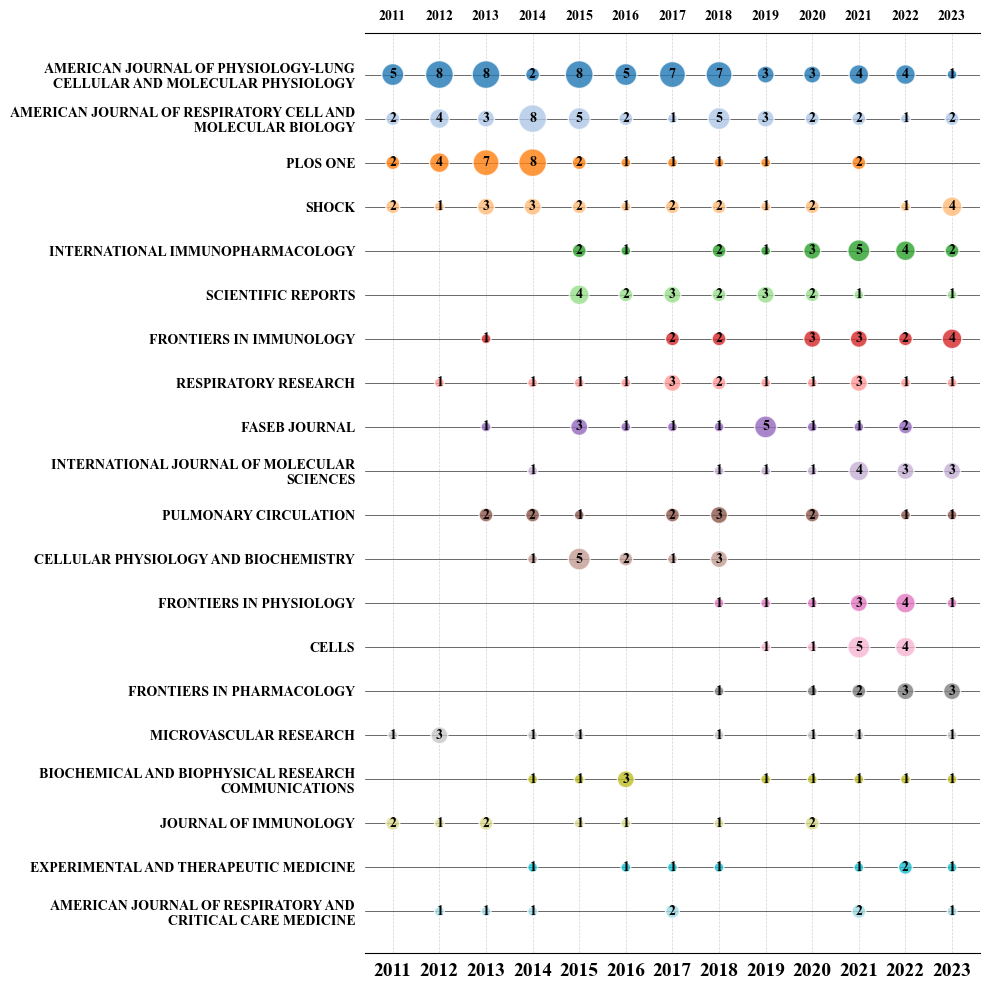

In [5]:
# Set the global font to Times New Roman.
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"

# Read CSV file.
file_path = 'Bubble_journals_data.csv'
df = pd.read_csv(file_path)

# Top 20 research fields by total number of publications.
top_30_keywords = df.nlargest(20, 'total publications')[::-1]

# Define the color.
colors = sns.color_palette("tab20", 30)

plt.figure(figsize=[10, 10])

plt.xticks(fontsize=14, fontweight='bold', fontname='Times New Roman')
plt.yticks(fontsize=10, fontweight='bold', fontname='Times New Roman')

# Hide the y-axis tick marks.
plt.tick_params(axis='y', which='both', left=False)
plt.tick_params(axis='x', which='both', bottom=False, top=False)

# Add gridlines.
plt.grid(axis='y', linestyle='-', linewidth=0.5, color='#2E2E2E')
plt.grid(axis='x', linestyle='--', linewidth=0.5, color='lightgray')

# Hide the outer border lines on both sides.
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Creating Bubble Chart
for index, row in top_30_keywords.iterrows():
    keyword = row['journal']
    yearly_data = row[2:].values
    years = top_30_keywords.columns[2:]

    sizes = yearly_data.astype(int) * 50
    color = colors[index % 30]

    plt.scatter(years, [keyword]*len(years), s=sizes, c=[color]*len(years), alpha=0.8, edgecolors='w', zorder=3)
    
    for year, publications, size in zip(years, yearly_data, sizes):
        if publications > 0:
            plt.text(year, keyword, int(publications), ha='center', va='center', color='black')

# Display the scale labels at the top.
plt.tick_params(labeltop=True)

# Hide axis labels.
plt.xlabel('')
plt.ylabel('')

# Customize the y-axis scale to accommodate long labels.
custom_ticks = top_30_keywords['journal'].apply(lambda x: textwrap.fill(x, 40))
plt.yticks(ticks=top_30_keywords['journal'].values, labels=custom_ticks)

# Save the image.
if not os.path.exists('pictures'):
    os.makedirs('pictures')
plt.tight_layout()
plt.savefig('pictures/Bubble_Chart_journal.svg', format='svg')

# Display the image.
plt.show()

## 3.5 WOS research area

### 3.5.1 Processing WC field lines in txt files

In [270]:
file_paths = ["05_final_WOS_1.txt", "05_final_WOS_2.txt"]

def process_file(input_file_path, output_file_path):
    with open(input_file_path, 'r', encoding='utf-8-sig') as infile, open(output_file_path, 'w', encoding='utf-8-sig') as outfile:
        appending = False
        current_line = ''
        for line in infile:
            stripped_line = line.strip()
            if stripped_line.startswith('WC '):
                current_line = stripped_line
                appending = True
                continue
            if appending and line.startswith(' '):
                current_line += ' ' + stripped_line
                continue
            if appending:
                appending = False
                outfile.write(current_line + '\n')
                current_line = ''
            outfile.write(line)

for index, file_path in enumerate(file_paths):
    process_file(file_path, f"processed_{index}.txt")

print("Files processed successfully.")

Files processed successfully.


### 3.5.2 Publications, Citations, and h-index

In [271]:
total_publications = 972
file_paths = ['processed_0.txt', 'processed_1.txt']
research_field_publications = defaultdict(int)
research_field_citations = defaultdict(int)
research_field_citation_list = defaultdict(list)

def calculate_h_index(citations):
    citations.sort(reverse=True)
    h_index = 0
    for i in range(len(citations)):
        if citations[i] >= i + 1:
            h_index = i + 1
        else:
            break
    return h_index

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        citation_count = 0
        for line in file:
            line = line.strip()

            if line.startswith('TC '):
                try:
                    citation_count = int(line[3:].strip())
                except ValueError:
                    print(f"Skipping unexpected line: {line}")
                    continue

            if line.startswith('WC '):
                research_fields = line[3:].strip().split(';')
                for field in research_fields:
                    field = field.strip()
                    research_field_citations[field] += citation_count
                    research_field_publications[field] += 1
                    research_field_citation_list[field].append(citation_count)

research_field_data = []
for field, count in research_field_publications.items():
    h_index = calculate_h_index(research_field_citation_list[field])
    avg_citations = round(research_field_citations[field] / count, 2)
    percentage_of_articles = round((count / total_publications) * 100, 2)
    research_field_data.append((field, count, research_field_citations[field], h_index, avg_citations, percentage_of_articles))

research_field_data.sort(key=lambda x: x[1], reverse=True)

with open('Data_Research_Area.csv', 'w', newline='', encoding='utf-8-sig') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Research Field", "Publications", "Citations", "h-index", "Average Citations per Publication", "the percentage of articles of institutions in total publications"])
    for row in research_field_data:
        writer.writerow(row)

print("Data saved to 'Data_Research_Area.csv'.")

Data saved to 'Data_Research_Area.csv'.


### 3.5.3 Publications of WOS research area by Year

In [272]:
file_paths = ['processed_0.txt', 'processed_1.txt']
fields_publications = defaultdict(int)
fields_yearly_publications = defaultdict(lambda: defaultdict(int))

all_years = set()
current_year = None  # Year used to save the current document.

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        for line in file:
            line = line.strip()
            
            # Read the PY line and save the year of the current document.
            if line.startswith('PY '):
                try:
                    current_year = int(line[3:].strip())
                    all_years.add(current_year)
                except ValueError:
                    print(f"Skipping unexpected line: {line}")
                    continue

            # Read WC lines and save research areas.
            elif line.startswith('WC '):
                fields = line[3:].strip().split(';')
                fields = [field.strip() for field in fields]
                for field in fields:
                    if current_year is not None:
                        fields_publications[field] += 1
                        fields_yearly_publications[field][current_year] += 1
            
            # Read the ER line and clear the current document's year.
            elif line.startswith('ER '):
                current_year = None

all_years = sorted(list(all_years))

fields_data = []

for field, total_count in fields_publications.items():
    row = [field, total_count] + [fields_yearly_publications[field][year] for year in all_years]
    fields_data.append(row)

fields_data.sort(key=lambda x: x[1], reverse=True)

with open('Bubble_fields_data.csv', 'w', newline='', encoding='utf-8-sig') as csvfile:
    writer = csv.writer(csvfile)
    header = ["researchfields", "total publications"] + [str(year) for year in all_years]
    writer.writerow(header)
    for row in fields_data:
        writer.writerow(row)

print("Data saved to 'Bubble_fields_data.csv'.")

Data saved to 'Bubble_fields_data.csv'.


### 3.5.4 Bubble Chart of Top 20 WOS research area by Year

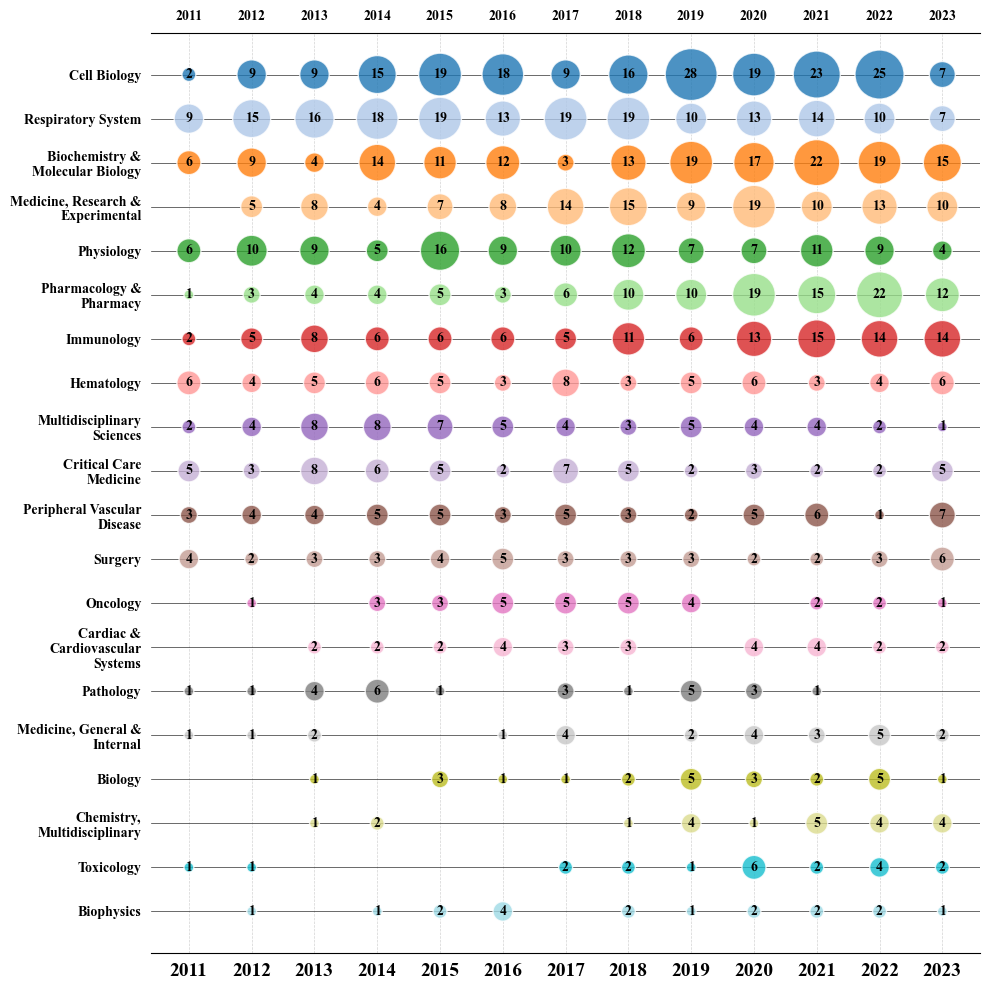

In [273]:
# Set the global font to Times New Roman.
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"

# Read CSV file.
file_path = 'Bubble_fields_data.csv'
df = pd.read_csv(file_path)

# Top 20 research fields by total number of publications.
top_30_keywords = df.nlargest(20, 'total publications')[::-1]

# Define the color.
colors = sns.color_palette("tab20", 30)

plt.figure(figsize=[10, 10])

plt.xticks(fontsize=14, fontweight='bold', fontname='Times New Roman')
plt.yticks(fontsize=10, fontweight='bold', fontname='Times New Roman')

# Hide the y-axis tick marks.
plt.tick_params(axis='y', which='both', left=False)
plt.tick_params(axis='x', which='both', bottom=False, top=False)

# Add gridlines.
plt.grid(axis='y', linestyle='-', linewidth=0.5, color='#2E2E2E')
plt.grid(axis='x', linestyle='--', linewidth=0.5, color='lightgray')

# Hide the outer border lines on both sides.
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Creating Bubble Chart
for index, row in top_30_keywords.iterrows():
    keyword = row['researchfields']
    yearly_data = row[2:].values
    years = top_30_keywords.columns[2:]

    sizes = yearly_data.astype(int) * 50
    color = colors[index % 30]

    plt.scatter(years, [keyword]*len(years), s=sizes, c=[color]*len(years), alpha=0.8, edgecolors='w', zorder=3)
    
    for year, publications, size in zip(years, yearly_data, sizes):
        if publications > 0:
            plt.text(year, keyword, int(publications), ha='center', va='center', color='black')

# Display the scale labels at the top.
plt.tick_params(labeltop=True)

# Hide axis labels.
plt.xlabel('')
plt.ylabel('')

# Customize the y-axis scale to accommodate long labels.
custom_ticks = top_30_keywords['researchfields'].apply(lambda x: textwrap.fill(x, 20))
plt.yticks(ticks=top_30_keywords['researchfields'].values, labels=custom_ticks)

# Save the image.
if not os.path.exists('pictures'):
    os.makedirs('pictures')
plt.tight_layout()
plt.savefig('pictures/Bubble_Chart_fields.svg', format='svg')

# Display the image.
plt.show()

## 3.6 Author Keywords

### 3.6.1 Retrieve all documents that do not contain the field "DE"

In [274]:
file_paths = ['05_final_WOS_1.txt', '05_final_WOS_2.txt']
output_file_path = 'without_DE_records.txt'

count_without_DE = 0

with open(output_file_path, 'w', encoding='utf-8-sig') as outfile:
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8-sig') as infile:
            inside_record = False
            has_DE = False
            for line in infile:
                if line.startswith('PT '):
                    inside_record = True
                    record_lines = [line]
                    has_DE = False
                elif inside_record and line.startswith('DE '):
                    has_DE = True
                elif inside_record and line.startswith('ER'):
                    record_lines.append(line)
                    inside_record = False
                    if not has_DE:
                        count_without_DE += 1
                        outfile.writelines(record_lines)
                        outfile.write('\n')  
                elif inside_record:
                    record_lines.append(line)

print(f"Number of records without DE line: {count_without_DE}")
print(f"Records without DE line exported to {output_file_path}")

Number of records without DE line: 218
Records without DE line exported to without_DE_records.txt


### 3.6.2 Publications

In [275]:
file_paths = ['05_final_WOS_1.txt', '05_final_WOS_2.txt']
keywords_publications = defaultdict(int)
keywords_yearly_publications = defaultdict(lambda: defaultdict(int))

# Save all the years that appear.
all_years = set()

# Keywords for saving the current literature.
current_keywords = []

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        for line in file:
            line = line.strip()

            # Read line DE and save keywords.
            if line.startswith('DE '):
                current_keywords = line[3:].strip().split(';')
                current_keywords = [keyword.strip() for keyword in current_keywords]

            # Read the PY line and associate it with the current keyword.
            elif line.startswith('PY '):
                try:
                    publication_year = int(line[3:].strip())
                    all_years.add(publication_year)

                    # If there are keywords, perform a statistical analysis.
                    for keyword in current_keywords:
                        keywords_publications[keyword] += 1
                        keywords_yearly_publications[keyword][publication_year] += 1

                    # Clear the current keyword and prepare to process the next document.
                    current_keywords = []

                except ValueError:
                    print(f"Skipping unexpected line: {line}")
                    continue

all_years = sorted(list(all_years))

# Create a list to store keywords and their corresponding data.
keywords_data = []

# Save data to a list.
for keyword, total_count in keywords_publications.items():
    row = [keyword, total_count] + [keywords_yearly_publications[keyword][year] for year in all_years]
    keywords_data.append(row)

# Sort in descending order based on the value of the "total publications" column.
keywords_data.sort(key=lambda x: x[1], reverse=True)

# Save the sorted results
with open('Bubble_keywords_data.csv', 'w', newline='', encoding='utf-8-sig') as csvfile:
    writer = csv.writer(csvfile)
    header = ["authorkeywords", "total publications"] + [str(year) for year in all_years]
    writer.writerow(header)
    for row in keywords_data:
        writer.writerow(row)

print("Data saved to 'Bubble_keywords_data.csv'.")

Data saved to 'Bubble_keywords_data.csv'.


### 3.6.3 Bubble Chart of Top 30 Author Keywords by Year

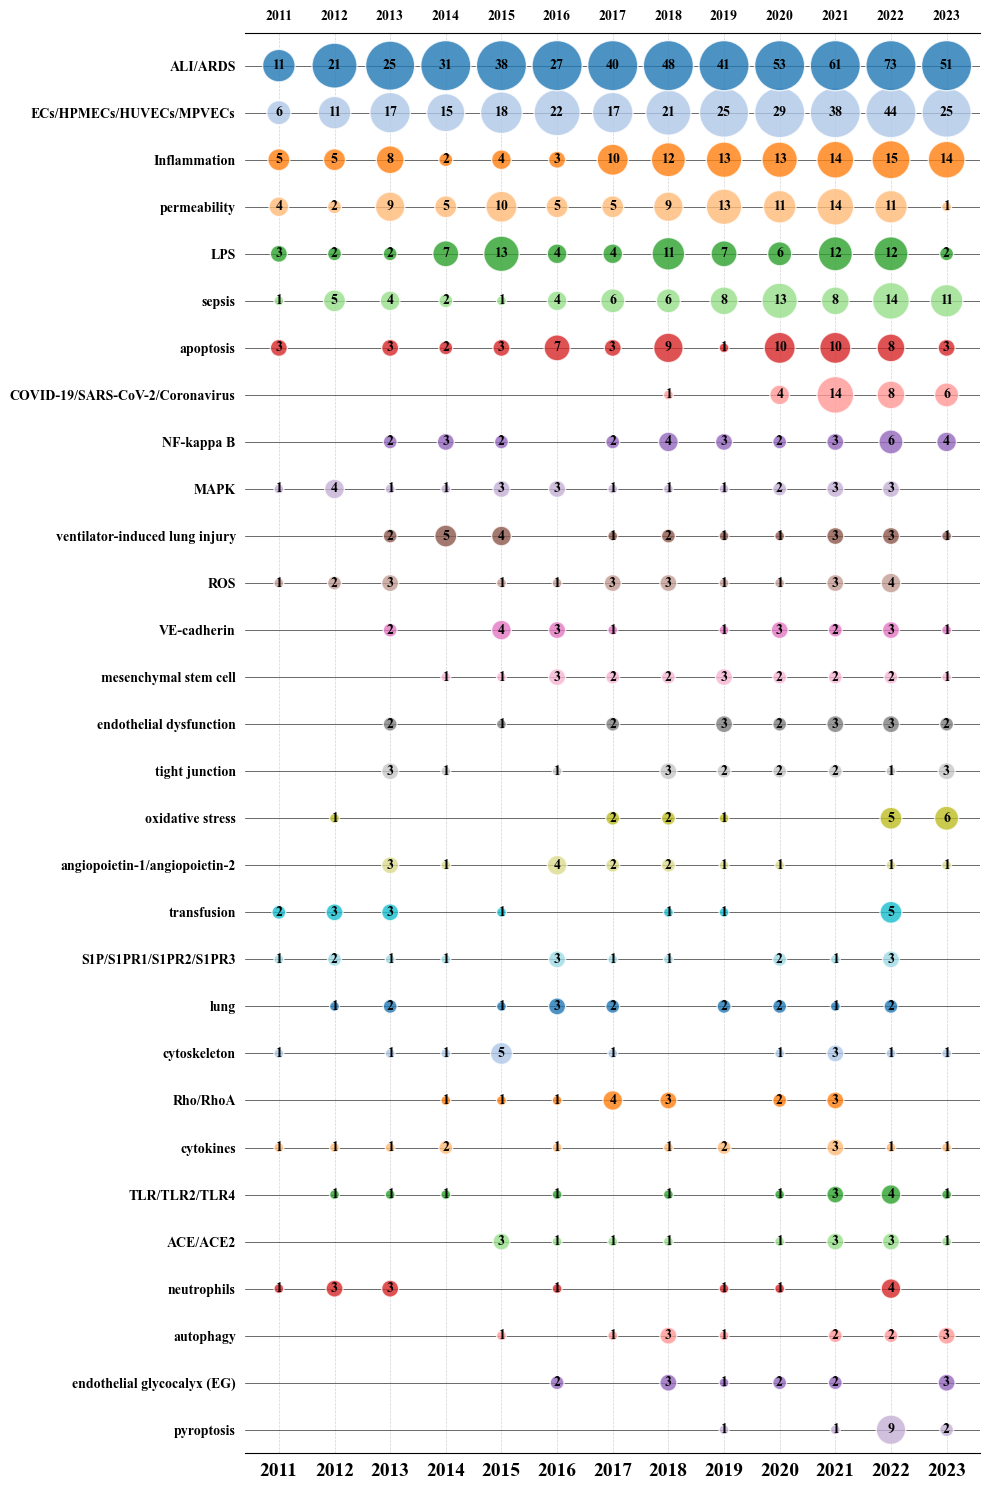

In [276]:
# Set the global font to Times New Roman.
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"

# Read CSV file.
file_path = 'Bubble_keywords_data.csv'
df = pd.read_csv(file_path)

# Retrieve the keywords of the top 30 authors based on their total number of published articles.
top_30_keywords = df.nlargest(30, 'total publications')[::-1]

# Define the color.
colors = sns.color_palette("tab20", 30) 

plt.figure(figsize=[10, 15])

plt.xticks(fontsize=14, fontweight='bold', fontname='Times New Roman')
plt.yticks(fontsize=10, fontweight='bold', fontname='Times New Roman')

# Hide the tick marks on the x and y axes.
plt.tick_params(axis='y', which='both', left=False)
plt.tick_params(axis='x', which='both', bottom=False, top=False)

# Add gridlines.
plt.grid(axis='y', linestyle='-', linewidth=0.5, color='#2E2E2E')
plt.grid(axis='x', linestyle='--', linewidth=0.5, color='lightgray')

# Hide the outer border lines on both sides.
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.ylim(-0.5, len(top_30_keywords['authorkeywords']) - 0.3)

# Define the maximum size of the bubble.
MAX_BUBBLE_SIZE = 1300

# Draw a bubble chart.
for index, row in top_30_keywords.iterrows():
    keyword = row['authorkeywords']
    yearly_data = row[2:].values
    years = top_30_keywords.columns[2:]

    sizes = np.minimum(yearly_data.astype(int) * 50, MAX_BUBBLE_SIZE)  # 确保气泡尺寸不超过最大值
    color = colors[index % 30]

    plt.scatter(years, [keyword]*len(years), s=sizes, c=[color]*len(years), alpha=0.8, edgecolors='w', zorder=3)    

    for year, publications, size in zip(years, yearly_data, sizes):
        if publications > 0:
            plt.text(year, keyword, int(publications), ha='center', va='center', color='black')

# Display the scale labels at the top.
plt.tick_params(labeltop=True)

# Hide axis labels.
plt.xlabel('')
plt.ylabel('')

# Customize the y-axis scale to accommodate long labels.
custom_ticks = top_30_keywords['authorkeywords'].apply(lambda x: textwrap.fill(x, 40))
plt.yticks(ticks=top_30_keywords['authorkeywords'].values, labels=custom_ticks)

# Save the image.
if not os.path.exists('pictures'):
    os.makedirs('pictures')
plt.tight_layout()
plt.savefig('pictures/Bubble_Chart_AuthorKeywords.svg', format='svg')

# Display the image.
plt.show()